# Données WFP - Admin 1

In [10]:
import sys
import os

# Détection automatique de la racine du projet
# On remonte d'un niveau depuis le dossier 'notebooks'
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Ajout au path pour pouvoir faire "from src..."
if project_root not in sys.path:
    sys.path.append(project_root)

# Définition des chemins absolus
DATA_RAW = os.path.join(project_root, "data", "raw")
DATA_PROCESSED = os.path.join(project_root, "data", "processed")
GEO_PATH = os.path.join(project_root, "geo")

print(f"Système configuré. Racine : {project_root}")

Système configuré. Racine : c:\Users\valen\OneDrive\Documents\GitHub\Projet-de-Statapp---WFP-


In [6]:
import pandas as pd
import os

# ==============================================================================
# 1. CONFIGURATION DES CHEMINS
# ==============================================================================
# Ton fichier météo (généré à l'étape précédente)
fldas_path = "../data/raw/FLDAS_Nigeria_Admin2_Aggregated.csv" 
# Le fichier WFP 
wfp_path = "../data/raw/WFP_food_security_data_nigeria.csv"
# Fichier de sortie
output_path = "../data/processed/NIGERIA_WFP_ADMIN1.csv"


In [7]:
# ==============================================================================
# 2. TRAITEMENT CLIMAT (ADMIN 2 -> ADMIN 1)
# ==============================================================================
print("1. Chargement et agrégation des données climatiques...")
df_clim = pd.read_csv(fldas_path)
df_clim['time'] = pd.to_datetime(df_clim['time'])

#On regroupe par DATE et par ÉTAT (NAME_1)
# On fait la moyenne de toutes les LGA (NAME_2) qui sont dans cet état
df_clim_admin1 = df_clim.groupby(['time', 'NAME_1']).mean(numeric_only=True).reset_index()


# 2. CORRECTION DES NOMS 
df_clim_admin1['NAME_1'] = df_clim_admin1['NAME_1'].replace({
    'FederalCapitalTerritory': 'Abuja',  # Le plus important
    'AkwaIbom': 'Akwa Ibom',             # Manque l'espace
    'CrossRiver': 'Cross River',         # Manque l'espace
    'Nasarawa': 'Nassarawa',             # Orthographe avec 2 's' souvent utilisée dans WFP
    'Nassarawa': 'Nassarawa'             # Sécurité si déjà avec 2 s
})

print(f"   -> Données climatiques agrégées au niveau État : {df_clim_admin1.shape}")


1. Chargement et agrégation des données climatiques...
   -> Données climatiques agrégées au niveau État : (2664, 28)


In [8]:

# ==============================================================================
# 3. TRAITEMENT WFP (CIBLE)
# ==============================================================================
print("2. Préparation des données WFP...")
df_wfp = pd.read_csv(wfp_path)

# Création d'une vraie colonne Date (1er du mois)
# On prend l'année du 'quarter' (ex: "2023Q1" -> 2023) et le mois
df_wfp['year'] = df_wfp['quarter'].str[:4].astype(int)
df_wfp['time'] = pd.to_datetime(df_wfp[['year', 'month']].assign(day=1))

# On renomme pour avoir la même clé de jointure
df_wfp = df_wfp.rename(columns={'ADM1_NAME': 'NAME_1'})

# On garde les colonnes utiles
cols_wfp = ['time', 'NAME_1', 'inadequate']
df_wfp_clean = df_wfp[cols_wfp]

print(f"   -> Données WFP prêtes : {df_wfp_clean.shape}")


2. Préparation des données WFP...
   -> Données WFP prêtes : (1010, 3)


In [9]:

# ==============================================================================
# 4. FUSION (MERGE)
# ==============================================================================
print("3. Fusion des deux fichiers...")

# Inner join : on garde uniquement les lignes où on a LA MÉTÉO ET LA CIBLE
df_final = pd.merge(df_wfp_clean, df_clim_admin1, on=['time', 'NAME_1'], how='inner')

# Sauvegarde
df_final.to_csv(output_path, index=False)

print("-" * 30)
print(f"✅ SUCCÈS ! Fichier fusionné sauvegardé : {output_path}")
print(f"Dimensions finales : {df_final.shape}")
print(f"Période couverte : {df_final['time'].min().date()} au {df_final['time'].max().date()}")
print("-" * 30)

# Aperçu
display(df_final.tail())

3. Fusion des deux fichiers...
------------------------------
✅ SUCCÈS ! Fichier fusionné sauvegardé : ../data/processed/NIGERIA_WFP_ADMIN1.csv
Dimensions finales : (973, 29)
Période couverte : 2023-01-01 au 2025-12-01
------------------------------


,time,NAME_1,inadequate,bnds,Y,X,Evap_tavg,LWdown_f_tavg,Lwnet_tavg,Psurf_f_tavg,...,Tair_f_tavg,Wind_f_tavg,SoilMoi00_10cm_tavg,SoilMoi10_40cm_tavg,SoilMoi40_100cm_tavg,SoilMoi100_200cm_tavg,SoilTemp00_10cm_tavg,SoilTemp10_40cm_tavg,SoilTemp40_100cm_tavg,SoilTemp100_200cm_tavg
968,2025-12-01,Rivers,0.160714,0.5,4.823889,6.987234,0.000034,411.810330,-43.801556,100792.671190,...,299.888003,2.907054,0.405510,0.406853,0.417039,0.441677,299.747586,299.546677,299.288960,298.954850
969,2025-12-01,Sokoto,0.456522,0.5,13.043215,5.325762,0.000008,335.779078,-115.339913,97790.403591,...,299.638528,6.335776,0.162425,0.324289,0.333883,0.367944,299.868678,299.929751,300.027598,300.237000
970,2025-12-01,Taraba,0.171429,0.5,8.169318,10.847254,0.000013,357.799072,-108.668333,96841.153500,...,301.657993,4.059479,0.196618,0.341409,0.351616,0.379171,302.027061,301.093865,300.262063,299.349812
971,2025-12-01,Yobe,0.736111,0.5,12.280427,11.269654,0.000007,326.325605,-121.448792,96968.869706,...,298.597382,6.557438,0.148997,0.309747,0.319463,0.352666,299.414977,299.629153,299.892923,300.272008
972,2025-12-01,Zamfara,0.326923,0.5,12.281723,6.331793,0.000011,335.686780,-117.691993,96429.503643,...,299.681968,6.764253,0.150952,0.312316,0.324905,0.367590,300.202766,300.077284,299.990443,299.937183


# Fusion avec NDVI

In [5]:
import pandas as pd
import os

# Fichiers
csv_ndvi = '../data/raw/NDVI.csv'
parquet_ndvi = '../data/raw/NDVI.parquet'
csv_wfp = '../data/processed/NIGERIA_WFP_ADMIN1.csv'
parquet_wfp = '../data/processed/NIGERIA_WFP_ADMIN1.parquet'

print("1. Conversion de WFP (Rapide)...")
# Le fichier WFP est petit, on le convertit direct
df_wfp = pd.read_csv(csv_wfp)
df_wfp['time'] = pd.to_datetime(df_wfp['time'])
df_wfp.to_parquet(parquet_wfp, index=False)
print("✅ WFP converti en Parquet.")

print("2. Conversion de NDVI (Morceau par morceau pour économiser la RAM)...")
# On lit le CSV par paquets de 100 000 lignes
chunksize = 100000
chunks = []

# On définit les types pour aider la lecture
types_opti = {'adm_level': 'int8', 'vim': 'float32', 'viq': 'float32'}

num = 0
for chunk in pd.read_csv(csv_ndvi, sep=';', chunksize=chunksize, dtype=types_opti):
    # On filtre tout de suite pour ne garder que ce qui est utile
    chunk = chunk[chunk['adm_level'] == 1].copy()
    
    # Conversion date immédiate
    chunk['date'] = pd.to_datetime(chunk['date'], dayfirst=True)
    
    # On ajoute à la liste
    chunks.append(chunk)
    num += 1
    if num % 10 == 0:
        print(f"   Traitement du bloc {num}...")

# On recolle les morceaux (concat)
print("   Assemblage final...")
df_full = pd.concat(chunks, ignore_index=True)

# Sauvegarde en Parquet
print("   Sauvegarde en Parquet...")
df_full.to_parquet(parquet_ndvi, index=False, compression='snappy')
print(f"✅ NDVI converti ! Taille sur le disque : {os.path.getsize(parquet_ndvi) / 1024 / 1024:.2f} MB")

1. Conversion de WFP (Rapide)...
✅ WFP converti en Parquet.
2. Conversion de NDVI (Morceau par morceau pour économiser la RAM)...
   Assemblage final...
   Sauvegarde en Parquet...
✅ NDVI converti ! Taille sur le disque : 0.38 MB


In [ ]:
import pandas as pd

# On lit les fichiers Parquet
print("Chargement ultra-rapide des Parquets...")

# L'avantage du Parquet : on ne charge QUE les colonnes utiles !
# Plus besoin de charger 'adm_level' ou 'adm_id', on gagne une RAM énorme.
df_ndvi = pd.read_parquet(
    '../data/raw/NDVI.parquet', 
    columns=['date', 'PCODE', 'vim', 'viq'] 
)

df_wfp = pd.read_parquet('../data/processed/NIGERIA_WFP_ADMIN1.parquet')

print(f"NDVI chargé : {df_ndvi.shape}")

# --- Traitement (Identique à avant, mais bcp plus rapide) ---

print("Traitement...")
# Création mois (Dates déjà au bon format grâce au Parquet !)
df_ndvi['month'] = df_ndvi['date'] + pd.offsets.MonthBegin(-1)

# Mapping
mapping_etats = {
    'NG001': 'Abia', 'NG002': 'Adamawa', 'NG003': 'Akwa Ibom', 'NG004': 'Anambra',
    'NG005': 'Bauchi', 'NG006': 'Bayelsa', 'NG007': 'Benue', 'NG008': 'Borno',
    'NG009': 'Cross River', 'NG010': 'Delta', 'NG011': 'Ebonyi', 'NG012': 'Edo',
    'NG013': 'Ekiti', 'NG014': 'Enugu', 'NG015': 'Abuja',
    'NG016': 'Gombe', 'NG017': 'Imo', 'NG018': 'Jigawa', 'NG019': 'Kaduna',
    'NG020': 'Kano', 'NG021': 'Katsina', 'NG022': 'Kebbi', 'NG023': 'Kogi',
    'NG024': 'Kwara', 'NG025': 'Lagos', 'NG026': 'Nasarawa', 'NG027': 'Niger',
    'NG028': 'Ogun', 'NG029': 'Ondo', 'NG030': 'Osun', 'NG031': 'Oyo',
    'NG032': 'Plateau', 'NG033': 'Rivers', 'NG034': 'Sokoto', 'NG035': 'Taraba',
    'NG036': 'Yobe', 'NG037': 'Zamfara'
}
df_ndvi['state_name'] = df_ndvi['PCODE'].map(mapping_etats)

# Agrégation
ndvi_mensuel = df_ndvi.groupby(['month', 'state_name'])[['vim', 'viq']].mean().reset_index()

# Fusion
print("Fusion...")
df_final = pd.merge(
    df_wfp,
    ndvi_mensuel,
    left_on=['time', 'NAME_1'],
    right_on=['month', 'state_name'],
    how='left'
)

df_final.drop(columns=['month', 'state_name'], inplace=True, errors='ignore')

# On remet le résultat en CSV (ou en Parquet si tu préfères garder la performance !)
df_final.to_csv('NIGERIA_WFP_ADMIN1.csv', index=False)
print("Fini !")

Chargement ultra-rapide des Parquets...
NDVI chargé : (31376, 4)
Traitement...
Fusion...
✅ Fini !


In [12]:
import pandas as pd

# --- Configuration ---
file_wfp = '../data/processed/NIGERIA_WFP_ADMIN1.csv'
file_water = '../data/raw/water_area_NGA_adm2_daily.csv'
file_ndvi = '../data/raw/NDVI.csv' # Ou .parquet si tu l'as converti

print("📊 DIAGNOSTIC TEMPOREL DES FICHIERS")
print("-" * 40)

# 1. Check WFP (Ton référentiel)
df_wfp = pd.read_csv(file_wfp, usecols=['time'])
df_wfp['time'] = pd.to_datetime(df_wfp['time'])
start_wfp = df_wfp['time'].min()
end_wfp = df_wfp['time'].max()
print(f"🔹 WFP (Cible) : De {start_wfp.date()} à {end_wfp.date()}")

# 2. Check NDVI
# On lit juste la colonne date pour aller vite
try:
    df_ndvi = pd.read_csv(file_ndvi, sep=';', usecols=['date'])
    df_ndvi['date'] = pd.to_datetime(df_ndvi['date'], dayfirst=True)
    print(f"🔹 NDVI        : De {df_ndvi['date'].min().date()} à {df_ndvi['date'].max().date()}")
    
    # Verdict NDVI
    if df_ndvi['date'].min() <= start_wfp and df_ndvi['date'].max() >= end_wfp:
        print("   ✅ NDVI couvre toute la période !")
    else:
        print("   ⚠️ NDVI ne couvre pas tout (risque de NaNs sur les bords).")
except Exception as e:
    print(f"   ❌ Erreur lecture NDVI: {e}")

# 3. Check Water
try:
    df_water = pd.read_csv(file_water, usecols=['date'])
    df_water['date'] = pd.to_datetime(df_water['date'])
    print(f"🔹 WATER       : De {df_water['date'].min().date()} à {df_water['date'].max().date()}")
    
    # Verdict Water
    if df_water['date'].min() <= start_wfp and df_water['date'].max() >= end_wfp:
        print("   ✅ WATER couvre toute la période !")
    else:
        print("   ⚠️ ATTENTION : WATER est incomplet par rapport au WFP.")
        if df_water['date'].min() > start_wfp:
            print(f"      -> Il manquera des données avant {df_water['date'].min().date()}")
except Exception as e:
    print(f"   ❌ Erreur lecture WATER: {e}")

print("-" * 40)

📊 DIAGNOSTIC TEMPOREL DES FICHIERS
----------------------------------------
🔹 WFP (Cible) : De 2023-01-01 à 2025-12-01
🔹 NDVI        : De 2002-07-01 à 2026-01-11
   ✅ NDVI couvre toute la période !
🔹 WATER       : De 2024-08-22 à 2025-01-15
   ⚠️ ATTENTION : WATER est incomplet par rapport au WFP.
      -> Il manquera des données avant 2024-08-22
----------------------------------------


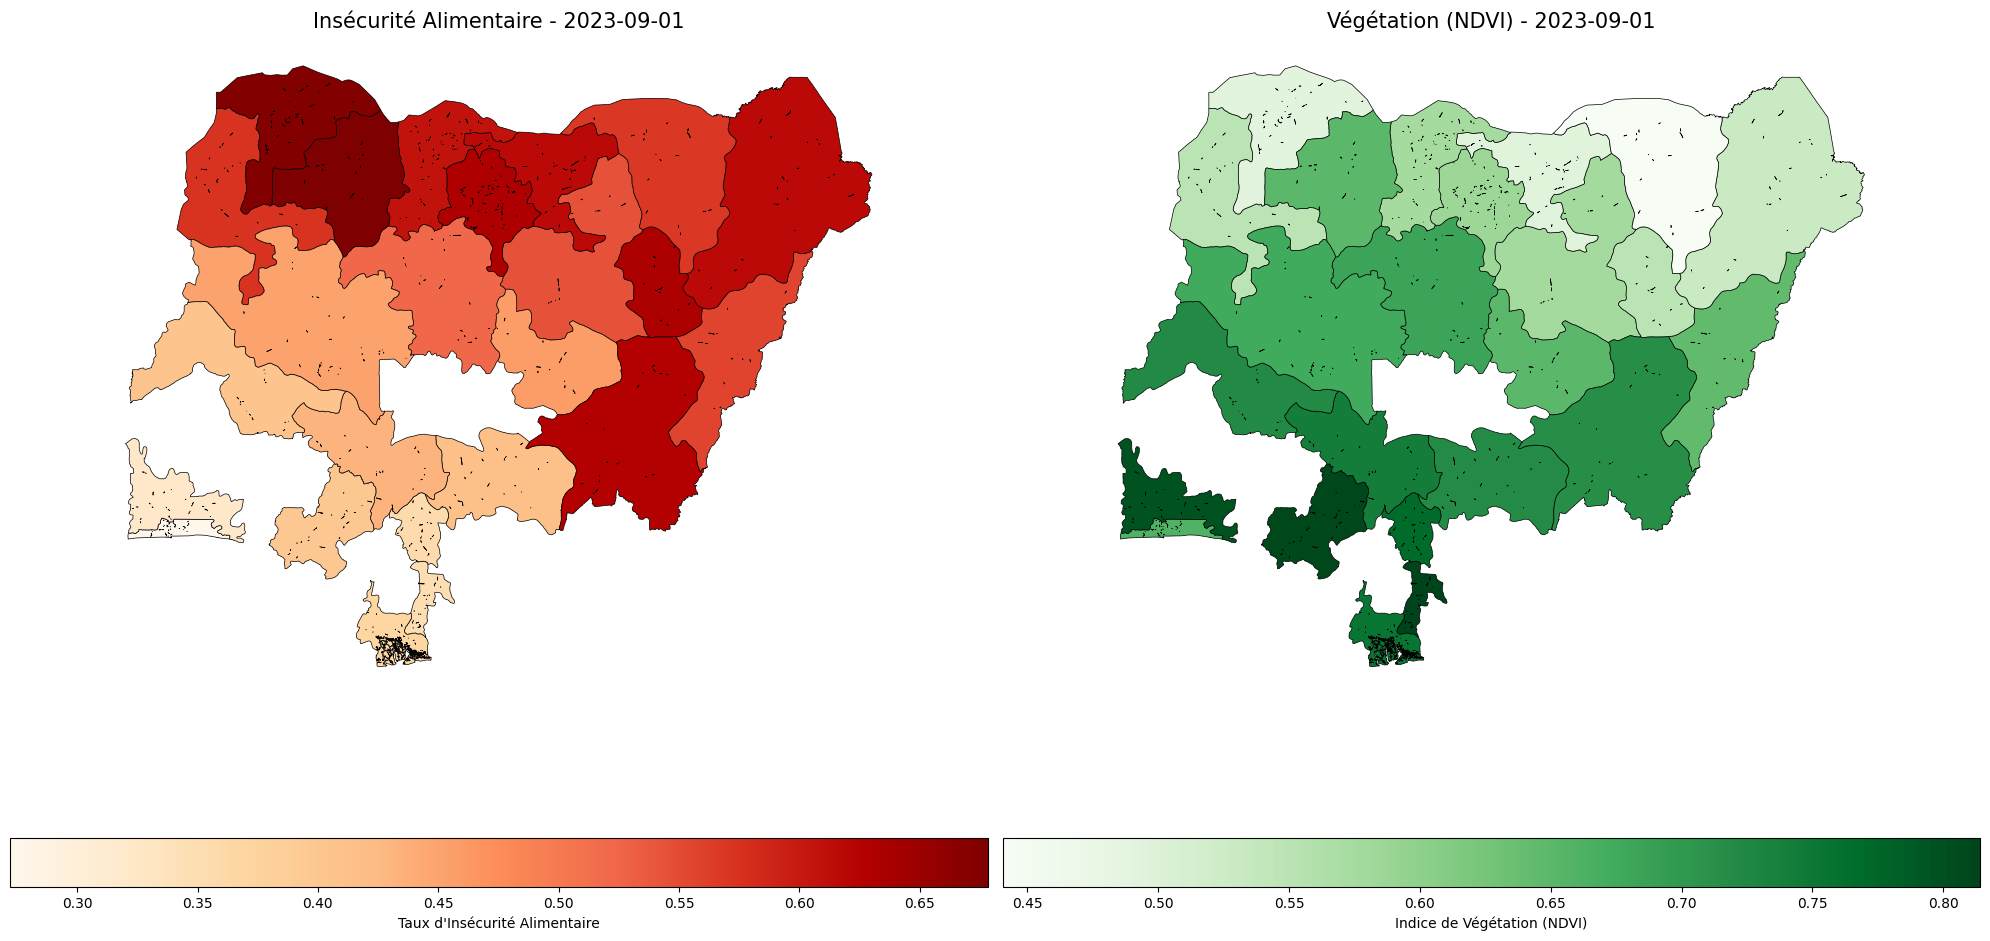

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# 1. Chargement des frontières (Admin 2 -> Admin 1)
# On charge le fichier JSON des LGA
gdf_lga = gpd.read_file('../geo/gadm41_NGA_2.json')  # Ajuste le chemin si besoin

# On fusionne les LGA pour obtenir les formes des ÉTATS (Admin 1)
# On regroupe par 'NAME_1' (le nom de l'état)
gdf_states = gdf_lga.dissolve(by='NAME_1')

# 2. Chargement de tes données WFP fusionnées
df_merged = pd.read_csv('../data/processed/NIGERIA_WFP_ADMIN1.csv')
df_merged['time'] = pd.to_datetime(df_merged['time'])

# 3. Préparation des données pour une date précise
date_cible = '2023-09-01'  # Choisis une date (ex: septembre = fin saison des pluies)
df_map = df_merged[df_merged['time'] == date_cible].copy()

# 4. Jointure Géographique (Tableau + Carte)
# On joint sur l'index (car dissolve a mis NAME_1 en index)
gdf_final = gdf_states.merge(df_map, left_index=True, right_on='NAME_1', how='left')

# 5. Création de la Carte (Double : Insecurity vs Vegetation)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Carte 1 : Insécurité Alimentaire
gdf_final.plot(column='inadequate', cmap='OrRd', legend=True, 
               ax=ax1, edgecolor='black', linewidth=0.5,
               legend_kwds={'label': "Taux d'Insécurité Alimentaire", 'orientation': "horizontal"})
ax1.set_title(f"Insécurité Alimentaire - {date_cible}", fontsize=15)
ax1.axis('off')

# Carte 2 : Végétation (NDVI)
gdf_final.plot(column='vim', cmap='Greens', legend=True, 
               ax=ax2, edgecolor='black', linewidth=0.5,
               legend_kwds={'label': "Indice de Végétation (NDVI)", 'orientation': "horizontal"})
ax2.set_title(f"Végétation (NDVI) - {date_cible}", fontsize=15)
ax2.axis('off')

plt.tight_layout()
plt.show()

1. Chargement des fichiers...
2. Fusion des géométries (LGA vers État)...
3. Jointure des données statistiques aux frontières...
4. Génération du graphique...


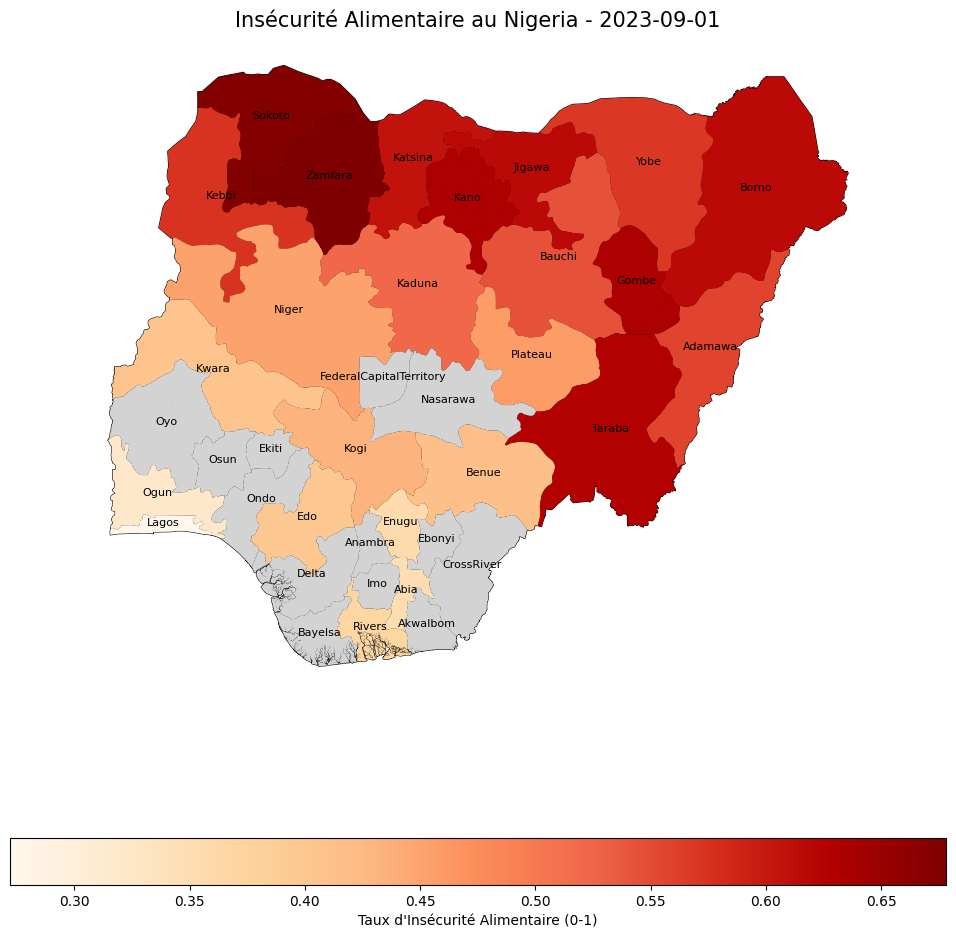

Carte terminée : nigeria_map_final.png


--- 🔍 Analyse des Valeurs Manquantes ---
⚠️ Attention, 2 colonnes contiennent des valeurs manquantes :


,Manquants (Nb),Pourcentage (%)
vim,26,2.67
viq,26,2.67


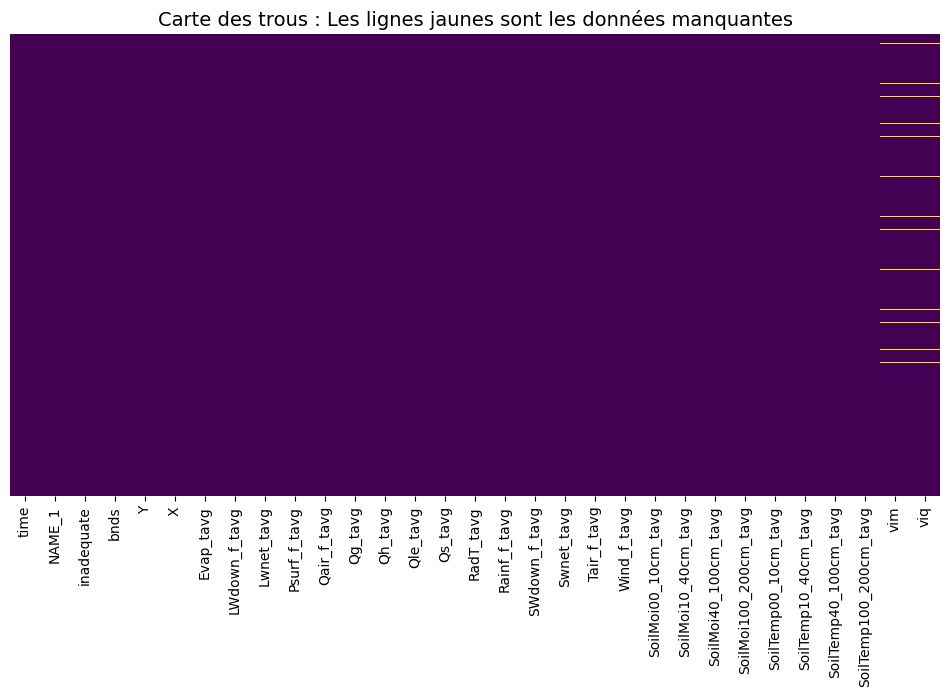

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Chargement des données
df = pd.read_csv('../data/processed/NIGERIA_WFP_ADMIN1.csv')

# 2. Calcul du nombre de NaN par colonne
print("--- 🔍 Analyse des Valeurs Manquantes ---")
# On compte les NaN
manquants = df.isna().sum()
# On calcule le pourcentage
pourcentage = (df.isna().mean() * 100).round(2)

# On rassemble tout dans un tableau propre
df_bilan = pd.DataFrame({
    'Manquants (Nb)': manquants, 
    'Pourcentage (%)': pourcentage
})

# On filtre pour n'afficher QUE les colonnes qui ont des problèmes
df_bilan = df_bilan[df_bilan['Manquants (Nb)'] > 0].sort_values(by='Manquants (Nb)', ascending=False)

if df_bilan.empty:
    print("✅ Bravo ! Ton dataset est complet à 100%. Aucun NaN trouvé.")
else:
    print(f"⚠️ Attention, {len(df_bilan)} colonnes contiennent des valeurs manquantes :")
    display(df_bilan) # Ou print(df_bilan) si tu n'es pas dans Jupyter

# 3. Visualisation graphique (Heatmap)
# C'est très utile pour voir si les manques sont groupés (ex: toute une année manquante)
if not df_bilan.empty:
    plt.figure(figsize=(12, 6))
    # heatmap : noir = donnée présente, blanc/jaune = donnée manquante
    sns.heatmap(df.isna(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title("Carte des trous : Les lignes jaunes sont les données manquantes", fontsize=14)
    plt.show()

In [2]:
import pandas as pd

# 1. Chargement des fichiers
df_main = pd.read_csv('../data/processed/NIGERIA_WFP_ADMIN1.csv')
df_spi = pd.read_csv('../data/raw/SPI.csv', sep=';')

# 2. Conversion ESSENTIELLE des dates (C'est ça qui manquait !)
df_main['time'] = pd.to_datetime(df_main['time'])

# 3. Préparation du fichier SPI
# On crée une colonne 'time' propre à partir de l'année et du mois
df_spi['day'] = 1
df_spi['time'] = pd.to_datetime(df_spi[['year', 'month', 'day']])

# On renomme la colonne 'State' pour qu'elle matche 'NAME_1'
df_spi = df_spi.rename(columns={'State': 'NAME_1'})

# CORRECTION ORTHOGRAPHIQUE : Nasarawa -> Nassarawa
df_spi['NAME_1'] = df_spi['NAME_1'].replace({'Nasarawa': 'Nassarawa'})

# On ne garde que les colonnes utiles
cols_to_keep = ['time', 'NAME_1', 'SPI_Cum1', 'SPI_Cum3', 'SPI_Cum6']
df_spi_clean = df_spi[cols_to_keep]

# 4. La Fusion (Merge)
# Maintenant que les deux 'time' sont au format datetime64, ça marche !
df_merged = pd.merge(df_main, df_spi_clean, on=['time', 'NAME_1'], how='left')

# 5. Vérification
print(f"Dimensions avant fusion : {df_main.shape}")
print(f"Dimensions après fusion : {df_merged.shape}")
print(f"Lignes avec SPI trouvé : {df_merged['SPI_Cum1'].notna().sum()}")

# Sauvegarde
df_merged.to_csv('../data/processed/NIGERIA_WFP_ADMIN1.csv', index=False)

Dimensions avant fusion : (973, 31)
Dimensions après fusion : (973, 34)
Lignes avec SPI trouvé : 923
